In [116]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pandas as pd

import copulagp.marginal as mg
from copulagp import bvcopula
import torch
from scipy import interpolate

LENGTH = 200 #cm long VR corridor

def plot_diff(data, cluster_id, file,
             n_bins = 200, m=5):
    [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]/LENGTH
    pos_t1 = ds_pos[trial_type==1]/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    trial_num_t0 = trial_num[trial_type==0]
    trial_num_t1 = trial_num[trial_type==1]
    cond_y_t0 = data.iloc[cluster_id].cond_y_t0
    cond_y_t1 = data.iloc[cluster_id].cond_y_t1

    n_bins=100

    def both_types_in_pos_bins(trial,pos,rate):
        A_t0 = np.zeros((len(np.unique(trial_num_t0)),n_bins))
        A_t1 = np.zeros((len(np.unique(trial_num_t1)),n_bins))
        for A_tx, trial_num_tx, pos_tx, u_rate_tx in zip([A_t0,A_t1],
                                                 trial,pos,rate):

            for j,trial in tqdm(enumerate(np.unique(trial_num_tx))):
                pos = pos_tx[trial_num_tx==trial]
                for i in range(n_bins):
                    mask = (pos>=(i-m)/n_bins) & (pos <=(i+1+m)/n_bins)
                    if np.sum(mask)!=0:
                        A_tx[j,i] = u_rate_tx[trial_num_tx==trial][mask].mean()

        return np.concatenate([A_t0,A_t1])
    A=both_types_in_pos_bins([trial_num_t0,trial_num_t1],[pos_t0, pos_t1],[ds_rate_t0,ds_rate_t1])
    B=both_types_in_pos_bins([trial_num_t0,trial_num_t1],[pos_t0, pos_t1],[cond_y_t0,cond_y_t1])

    Hz_range = np.mean(A,axis=0).max(0)*1.2 # mean FR at the location with the highest FR
    #     print(A.shape)
    plt.imshow(B,vmin=0,vmax=Hz_range)
    Hz_range = np.mean(A,axis=0).max(0)*0.5
    plt.imshow(A-B,vmin=-Hz_range,vmax=Hz_range,cmap="RdBu")
    plt.axhline(len(np.unique(trial_num_t0)),color='k',linestyle=':')
    plt.xticks([0,50],[0,100])
    plt.colorbar(label='<raw rate> - <conditional rate>')
    plt.xlabel('position, cm')
    plt.ylabel('trial #')
    plt.title(f'{data.iloc[cluster_id].session_id}, #{data.iloc[cluster_id].cluster_id}')
    # fig.colorbar(plot);
    plt.savefig(file)
    plt.close();

In [73]:
import glob

cohorts = glob.glob("Cohort*")
cohort = cohorts[0]
cohort

'Cohort7_october2020'

In [82]:

session_list = glob.glob(f"unified_copula/{cohort}/*.pkl")
session_list
    

['unified_copula/Cohort7_october2020/M4_D12_2020-11-13_15-08-51_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M7_D1_2020-10-29_15-44-22_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M3_D6_2020-11-05_14-37-17_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M3_D26_2020-12-03_14-51-03_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M6_D6_2020-11-05_15-50-22_50ms_copula.pkl',
 'unified_copula/Cohort7_october2020/M7_D26_2020-12-03_16-01-44_50ms_copula.pkl']

In [102]:
session_id=4
data = pd.read_pickle(session_list[session_id])
len(data)

15

In [103]:
diff_before_after=np.zeros((len(data),2))
for cluster_id in range(len(data)):
    [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
    pos_t0 = ds_pos[trial_type==0]#/LENGTH
    pos_t1 = ds_pos[trial_type==1]#/LENGTH
    ds_rate_t0 = ds_rate[trial_type==0]
    ds_rate_t1 = ds_rate[trial_type==1]
    cond_y_t0 = data.iloc[cluster_id].cond_y_t0
    cond_y_t1 = data.iloc[cluster_id].cond_y_t1

    diff_before_after[cluster_id] = (np.mean(np.abs(ds_rate_t0[pos_t0<90]-cond_y_t0[pos_t0<90])),np.mean(np.abs(ds_rate_t0[pos_t0>110]-cond_y_t0[pos_t0>110])))

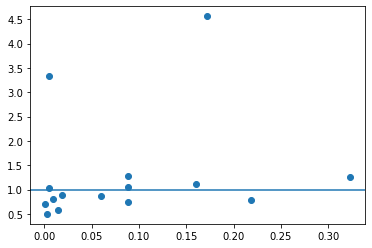

In [104]:
mask = diff_before_after[:,1]!=0

ratio = np.zeros_like(diff_before_after[:,0])
ratio[mask] = np.clip(diff_before_after[mask,0]/diff_before_after[mask,1],0,10.)

plt.scatter(diff_before_after[mask,0],ratio[mask])
plt.axhline(1.)
top=np.argmax(ratio[mask & (ratio!=10.)])
bottom=np.argmin(ratio[mask & (ratio!=0.)])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

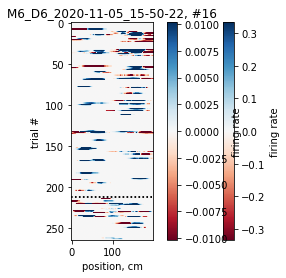

In [107]:
# plot_diff(data, cluster_id, )
session_name=(session_list[session_id].split('/')[-1]).split("_copula.pkl")[0]
save_name = lambda which: f"unified_copula/{cohort}/{session_name}_{which}.png"
plot_diff(data, top, save_name('top'))
# plot_diff(data, bottom, save_name('bottom'))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

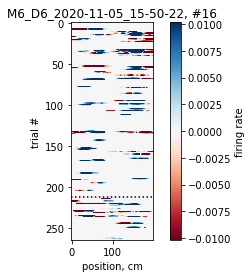

In [106]:
plot_diff(data, bottom, save_name('bottom'))

# Serialize

In [ ]:
session_list = glob.glob(f"unified_copula/{cohort}/*.pkl")
for session in tqdm(session_list):
    data = pd.read_pickle(session)

    diff_before_after=np.zeros((len(data),2))
    for cluster_id in range(len(data)):
        [ds_rate, ds_vel, ds_pos, trial_num, trial_type] = data.iloc[cluster_id].spikes_per50ms
        pos_t0 = ds_pos[trial_type==0]#/LENGTH
        pos_t1 = ds_pos[trial_type==1]#/LENGTH
        ds_rate_t0 = ds_rate[trial_type==0]
        ds_rate_t1 = ds_rate[trial_type==1]
        cond_y_t0 = data.iloc[cluster_id].cond_y_t0
        cond_y_t1 = data.iloc[cluster_id].cond_y_t1

        diff_before_after[cluster_id] = (np.mean(np.abs(ds_rate_t0[pos_t0<90]-cond_y_t0[pos_t0<90])),np.mean(np.abs(ds_rate_t0[pos_t0>110]-cond_y_t0[pos_t0>110])))
    
    mask = diff_before_after[:,1]!=0

    ratio = np.zeros_like(diff_before_after[:,0])
    ratio[mask] = np.clip(diff_before_after[mask,0]/diff_before_after[mask,1],0,10.)

    plt.scatter(diff_before_after[mask,0],ratio[mask])
    plt.axhline(1.)
    
    if len(ratio[mask & (ratio!=10.) & (ratio!=0.)])>0:
        top=np.max(ratio[mask & (ratio!=10.)])
        top_idx=np.argmax(ratio[mask & (ratio!=10.)])
        bottom=np.min(ratio[mask & (ratio!=0.)])
        bottom_idx=np.argmin(ratio[mask & (ratio!=0.)])

        session_name=(session.split('/')[-1]).split("_copula.pkl")[0]
        save_name = lambda which: f"unified_copula/{cohort}/{session_name}_{which}.png"
        plot_diff(data, top_idx, save_name('top'))
        plot_diff(data, bottom_idx, save_name('bottom'))

        if top>2.:
            save_name = f"interesting/effect_{cohort}_{session_name}.png"
            plot_diff(data, top_idx, save_name)

        if bottom<0.5:
            save_name = f"interesting/countereffect_{cohort}_{session_name}.png"
            plot_diff(data, bottom_idx, save_name)
    

    

  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]